<a href="https://colab.research.google.com/github/vektor8891/llm/blob/main/projects/20_instruction_tuning/20_instruction_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -qq datasets==2.20.0
# !pip install -qq evaluate==0.4.2
# !pip install -qq sacrebleu==2.4.2
# !pip install -qq trl==0.9.6

### Define the device

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset description

In [3]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/WzOT_CwDALWedTtXjwH7bA/CodeAlpaca-20k.json

--2025-06-03 12:39:06--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/WzOT_CwDALWedTtXjwH7bA/CodeAlpaca-20k.json
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6957007 (6.6M) [application/json]
Saving to: ‘CodeAlpaca-20k.json.1’

CodeAlpaca-20k.json 100%[===================>]   6.63M  --.-KB/s    in 0.1s    

2025-06-03 12:39:06 (49.4 MB/s) - ‘CodeAlpaca-20k.json.1’ saved [6957007/6957007]



In [4]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="CodeAlpaca-20k.json", split="train")
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['output', 'instruction', 'input'],
    num_rows: 20022
})

In [5]:
dataset[1000]

{'output': 's = "Hello world" \ns = s[::-1] \nprint(s)',
 'instruction': 'Reverse the string given in the input',
 'input': 'Hello world'}

In [6]:
dataset = dataset.filter(lambda example: example["input"] == '')

Filter:   0%|          | 0/20022 [00:00<?, ? examples/s]

In [7]:
dataset = dataset.shuffle(seed=42)

In [8]:
dataset

Dataset({
    features: ['output', 'instruction', 'input'],
    num_rows: 9764
})

In [25]:
# Select only the first 100 rows before splitting
# dataset_first_100 = dataset.select(range(100))
# dataset_first_100
# dataset_split = dataset_first_100.train_test_split(test_size=0.2, seed=42)

dataset_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset_split['train']
test_dataset = dataset_split['test']

Dataset({
    features: ['output', 'instruction', 'input'],
    num_rows: 100
})

In [26]:
# Select a small set of data for the resource limitation
# This dataset will be only used for evaluation parts, not for the training
tiny_test_dataset=test_dataset.select(range(10))
tiny_train_dataset=train_dataset.select(range(10))

# Model and tokenizer

In [27]:
from transformers import AutoModelForCausalLM

# Base model
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m").to(device)

In [28]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m", padding_side='left')

In [29]:
tokenizer.eos_token

'</s>'

# Preprocessing the data

In [30]:
def formatting_prompts_func(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Instruction:\n{mydataset['instruction'][i]}"
            f"\n\n### Response:\n{mydataset['output'][i]}</s>"
        )
        output_texts.append(text)
    return output_texts

def formatting_prompts_func_no_response(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Instruction:\n{mydataset['instruction'][i]}"
            f"\n\n### Response:\n"
        )
        output_texts.append(text)
    return output_texts

In [31]:
from tqdm import tqdm

expected_outputs = []
instructions_with_responses = formatting_prompts_func(test_dataset)
instructions = formatting_prompts_func_no_response(test_dataset)
for i in tqdm(range(len(instructions_with_responses))):
    tokenized_instruction_with_response = tokenizer(instructions_with_responses[i], return_tensors="pt", max_length=1024, truncation=True, padding=False)
    tokenized_instruction = tokenizer(instructions[i], return_tensors="pt")
    expected_output = tokenizer.decode(tokenized_instruction_with_response['input_ids'][0][len(tokenized_instruction['input_ids'][0])-1:], skip_special_tokens=True)
    expected_outputs.append(expected_output)

100%|██████████| 1953/1953 [00:02<00:00, 907.02it/s]


In [32]:
print('############## instructions ##############\n' + instructions[0])
print('############## instructions_with_responses ##############\n' + instructions_with_responses[0])
print('\n############## expected_outputs ##############' + expected_outputs[0])

############## instructions ##############
### Instruction:
Name the most important benefit of using a database system.

### Response:

############## instructions_with_responses ##############
### Instruction:
Name the most important benefit of using a database system.

### Response:
The most important benefit of using a database system is the ability to store and retrieve data quickly and easily. Database systems also provide support for data security, data integrity, and concurrently accessing and modifying data from multiple systems.</s>

############## expected_outputs ##############
The most important benefit of using a database system is the ability to store and retrieve data quickly and easily. Database systems also provide support for data security, data integrity, and concurrently accessing and modifying data from multiple systems.


In [17]:
from torch.utils.data import Dataset

class ListDataset(Dataset):
    def __init__(self, original_list):
        self.original_list = original_list

    def __len__(self):
        return len(self.original_list)

    def __getitem__(self, i):
        return self.original_list[i]

instructions_torch = ListDataset(instructions)

In [18]:
instructions_torch[0]

'### Instruction:\nDesign a regular expression to match strings that begin with the letter "a".\n\n### Response:\n'

# Test the base model

In [19]:
from transformers import pipeline

gen_pipeline = pipeline("text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        device=device,
                        batch_size=2,
                        max_length=50,
                        truncation=True,
                        padding=False,
                        return_full_text=False)

Device set to use cpu


In [20]:
tokenizer.padding_side = 'left'

with torch.no_grad():
    # Due to resource limitation, only apply the function on 3 records using "instructions_torch[:10]"
    pipeline_iterator= gen_pipeline(instructions_torch[:3],
                                    max_length=50, # this is set to 50 due to resource constraint, using a GPU, you can increase it to the length of your choice
                                    num_beams=5,
                                    early_stopping=True,)

generated_outputs_base = []
for text in pipeline_iterator:
    generated_outputs_base.append(text[0]["generated_text"])

In [21]:
from urllib.request import urlopen
import pickle
import io

# load generated responses from CUDA-enabled GPU machine
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/VvQRrSqS1P0_GobqtL-SKA/instruction-tuning-generated-outputs-base.pkl')
generated_outputs_base = pickle.load(io.BytesIO(urlopened.read()))

In [22]:
for i in range(3):
    print('@@@@@@@@@@@@@@@@@@@@')
    print('@@@@@ Instruction '+ str(i+1) +': ')
    print(instructions[i])
    print('\n\n')
    print('@@@@@ Expected response '+ str(i+1) +': ')
    print(expected_outputs[i])
    print('\n\n')
    print('@@@@@ Generated response '+ str(i+1) +': ')
    print(generated_outputs_base[i])
    print('\n\n')
    print('@@@@@@@@@@@@@@@@@@@@')

@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 1: 
### Instruction:
Design a regular expression to match strings that begin with the letter "a".

### Response:




@@@@@ Expected response 1: 

^a.*



@@@@@ Generated response 1: 
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.

### Response:
Thank you for your question.



@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 2: 
### Instruction:
Suggest a solution for validating a password which should contain at least 1 uppercase character, 1 lowercase character and 1 digit.

### Response:




@@@@@ Expected response 2: 

We can use a regular expression to validate a password. A regular expression to validate a password with at least 1 uppercase character, 1 lowercase character and 1 digit should be:

^(?=.*[a-z])(?=.*[A-Z])(?=.*\d).+$

If the password matches the regular expressio

Issues of base model responses:

1. responses not up to mark
1. tendency to eextend and repeat the answers

-> Instruction-tuning can fix both issues!

## BLEU score

In [34]:
# !pip install --upgrade evaluate

In [33]:
import evaluate

sacrebleu = evaluate.load("sacrebleu")
results_base = sacrebleu.compute(predictions=generated_outputs_base,
                                 references=expected_outputs)

print(list(results_base.keys()))
print(round(results_base["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
0.0


## Perform instruction fine-tuning with LoRA

In [35]:
from peft import get_peft_model, LoraConfig, TaskType

lora_config = LoraConfig(
    r=16,  # Low-rank dimension
    lora_alpha=32,  # Scaling factor
    target_modules=["q_proj", "v_proj"],  # Modules to apply LoRA
    lora_dropout=0.1,  # Dropout rate
    task_type=TaskType.CAUSAL_LM  # Task type should be causal language model
)

model = get_peft_model(model, lora_config)

In [36]:
from trl import DataCollatorForCompletionOnlyLM

response_template = "### Response:\n"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

In [37]:
from trl import SFTConfig, SFTTrainer


training_args = SFTConfig(
    output_dir="/tmp",
    num_train_epochs=10,
    save_strategy="epoch",
    fp16=True,
    per_device_train_batch_size=2,  # Reduce batch size
    per_device_eval_batch_size=2,  # Reduce batch size
    max_seq_length=1024,
    do_eval=True
)

trainer = SFTTrainer(
    model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    formatting_func=formatting_prompts_func,
    args=training_args,
    packing=False,
    data_collator=collator,
)

Map:   0%|          | 0/7811 [00:00<?, ? examples/s]

Map:   0%|          | 0/1953 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/trl/trainer/sft_trainer.py:413: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [38]:
#trainer.train()
#log_history_lora = trainer.state.log_history

In [40]:
import json

urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/49I70jQD0-RNRg2v-eOoxg/instruction-tuning-log-history-lora.json')
log_history_lora = json.load(io.BytesIO(urlopened.read()))

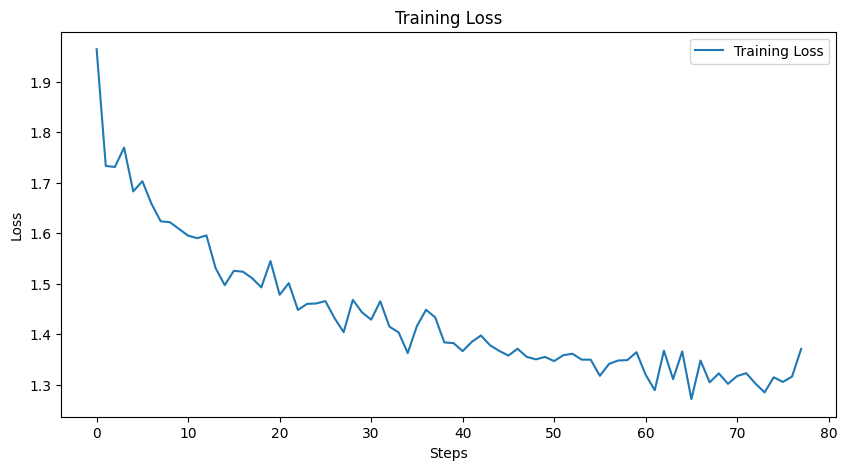

In [41]:
import matplotlib.pyplot as plt

train_loss = [log["loss"] for log in log_history_lora if "loss" in log]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [42]:
#trainer.save_model("./instruction_tuning_final_model_lora")

In [43]:
gen_pipeline = pipeline("text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        device=device,
                        batch_size=2,
                        max_length=50,
                        truncation=True,
                        padding=False,
                        return_full_text=False)

Device set to use cpu


In [44]:
with torch.no_grad():
    # Due to resource limitation, only apply the function on 3 records using "instructions_torch[:10]"
    pipeline_iterator= gen_pipeline(instructions_torch[:3],
                                max_length=50, # this is set to 50 due to resource constraint, using a GPU, you can increase it to the length of your choice
                                num_beams=5,
                                early_stopping=True,)
generated_outputs_lora = []
for text in pipeline_iterator:
    generated_outputs_lora.append(text[0]["generated_text"])

In [45]:
generated_outputs_lora[0]

'\n.\n.\n.\n.\n.\n.'

In [46]:
# load the generated texts for the entire dataset from the fine-tuned LoRA model and run on GPU
urlopened = urlopen('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/o7uYxe15xvX4CN-6Lr10iA/instruction-tuning-generated-outputs-lora.pkl')
generated_outputs_lora = pickle.load(io.BytesIO(urlopened.read()))

In [47]:
for i in range(3):
    print('@@@@@@@@@@@@@@@@@@@@')
    print('@@@@@ Instruction '+ str(i+1) +': ')
    print(instructions[i])
    print('\n\n')
    print('@@@@@ Expected response '+ str(i+1) +': ')
    print(expected_outputs[i])
    print('\n\n')
    print('@@@@@ Generated response '+ str(i+1) +': ')
    print(generated_outputs_lora[i])
    print('\n\n')
    print('@@@@@@@@@@@@@@@@@@@@')


@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 1: 
### Instruction:
Name the most important benefit of using a database system.

### Response:




@@@@@ Expected response 1: 

The most important benefit of using a database system is the ability to store and retrieve data quickly and easily. Database systems also provide support for data security, data integrity, and concurrently accessing and modifying data from multiple systems.



@@@@@ Generated response 1: 
The type of data structure to use to store key-value pairs in a Python program would be a key-value pair.



@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@
@@@@@ Instruction 2: 
### Instruction:
Come up with a Java program that checks if one string is a substring of another.

### Response:




@@@@@ Expected response 2: 

public static boolean isSubstring(String s, String x) {
    int i = 0, j = 0;
    while (i < s.length() && j < x.length()) {
        if (s.charAt(i) == x.charAt(j)) {
            i++;
            j++;
        } else {
     

In [48]:
sacrebleu = evaluate.load("sacrebleu")
results_lora = sacrebleu.compute(predictions=generated_outputs_lora,
                                 references=expected_outputs)
print(list(results_lora.keys()))
print(round(results_lora["score"], 1))

['score', 'counts', 'totals', 'precisions', 'bp', 'sys_len', 'ref_len']
1.2


### Exercise 1: Use another response template (Question-Answering)

In [50]:
def formatting_prompts_response_template(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Question:\n{mydataset['instruction'][i]}"
            f"\n\n### Answer:\n{mydataset['output'][i]}</s>"
        )
        output_texts.append(text)
    return output_texts

def formatting_prompts_response_template_no_response(mydataset):
    output_texts = []
    for i in range(len(mydataset['instruction'])):
        text = (
            f"### Question:\n{mydataset['instruction'][i]}"
            f"\n\n### Answer:\n"
        )
        output_texts.append(text)
    return output_texts

### Exercise 2: Try with another LLM (EleutherAI/gpt-neo-125m)

In [51]:
model_name = "EleutherAI/gpt-neo-125m"

# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

In [52]:
lora_config = LoraConfig(
    r=8,  # Low-rank dimension
    lora_alpha=16,  # Scaling factor
    target_modules=["q_proj", "v_proj"],  # Modules to apply LoRA
    lora_dropout=0.1,  # Dropout rate
    task_type=TaskType.CAUSAL_LM  # Task type should be causal language model
)

In [54]:
model = get_peft_model(model, lora_config)

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:79: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'EleutherAI/gpt-neo-125m' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [55]:
!pip freeze > requirements.txt